# Insurance Data
This Jupyter Notebook takes an insurance data set from Kaggle and looks into the relationships between the different parameters given. First, we check for a correlation (a linear relationship) between BMI and insurance charges, and then we see if being a smoker influences what you're charged by insurance companies using an A/B Test.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# read table
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Exploration

The best place to start with any data-oriented project is to figure out how the data look. To this end, we take a look at the distributions of the different data in the `insurance` DataFrame. The figure created below has a histogram or bar chart for each column to show the counts of the data contained therein.

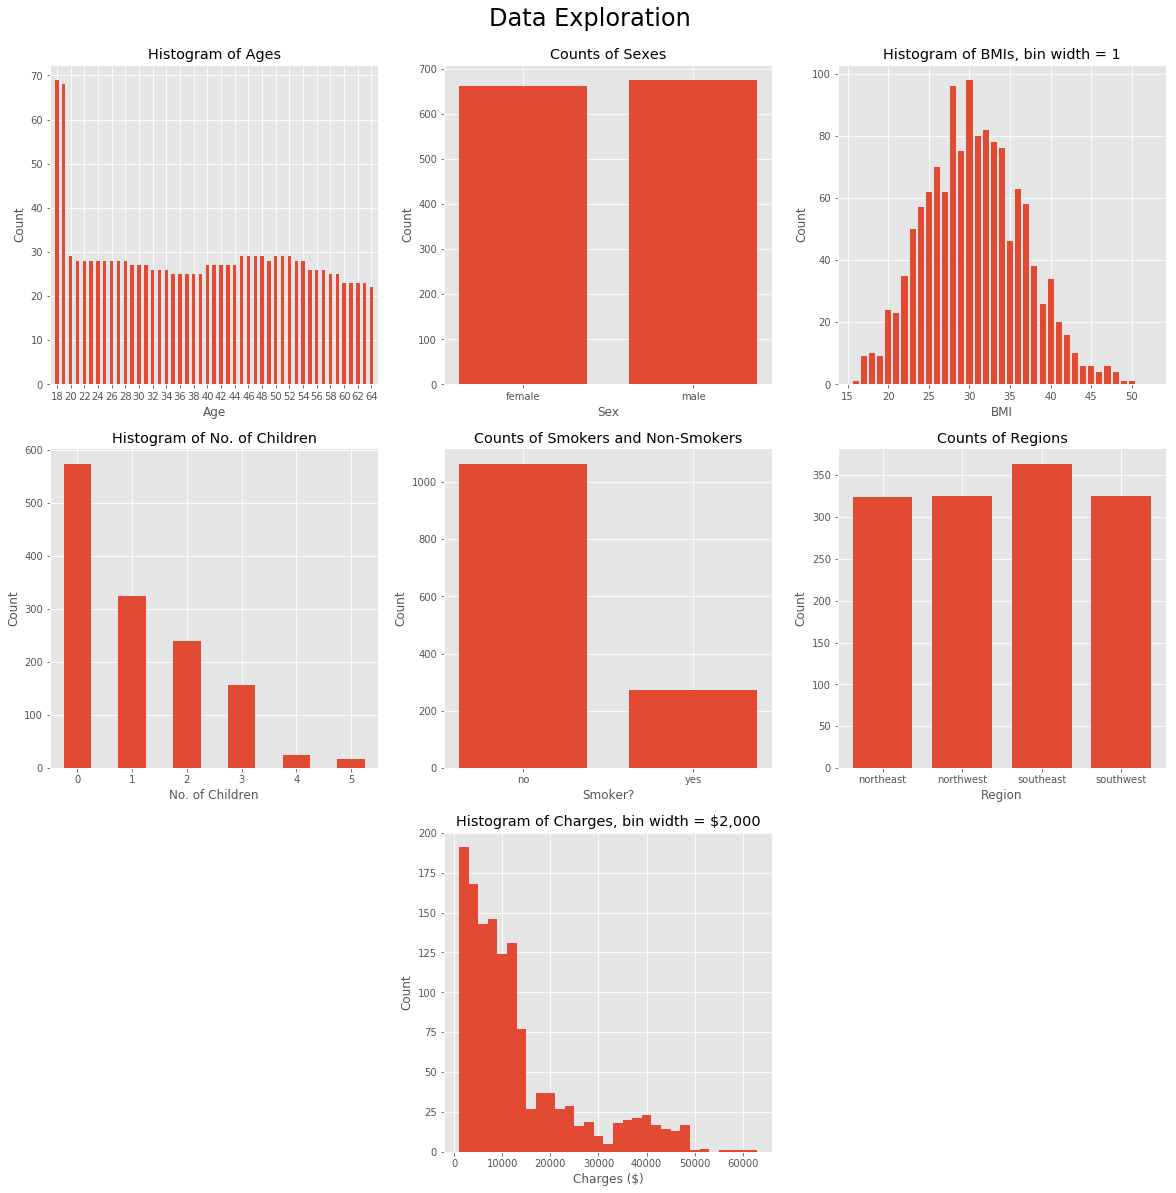

In [68]:
plt.figure(figsize=[20, 20])

plt.subplot(331)
plt.hist(insurance['age'], bins=np.arange(17.5, 65.5), rwidth=.5)
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(np.arange(18, 65, 2))
plt.xlim([17, 65])

ins_by_sex = insurance.groupby('sex').count()

plt.subplot(332)
plt.bar(ins_by_sex.index, ins_by_sex['age'], width=.75)
plt.title('Counts of Sexes')
plt.xlabel('Sex')
plt.ylabel('Count')

plt.subplot(333)
plt.hist(insurance['bmi'], bins=np.arange(15.5, 53.5, 1), rwidth=.75)
plt.title('Histogram of BMIs, bin width = 1')
plt.xlabel('BMI')
plt.ylabel('Count')

plt.subplot(334)
plt.hist(insurance['children'], bins=np.arange(-.5, 6.5, 1), rwidth=.5)
plt.title('Histogram of No. of Children')
plt.xlabel('No. of Children')
plt.ylabel('Count')
plt.xlim([-.5, 5.5])

ins_by_smoker = insurance.groupby('smoker').count()

plt.subplot(335)
plt.bar(ins_by_smoker.index, ins_by_smoker['age'], width=.75)
plt.title('Counts of Smokers and Non-Smokers')
plt.xlabel('Smoker?')
plt.ylabel('Count')

ins_by_region = insurance.groupby('region').count()

plt.subplot(336)
plt.bar(ins_by_region.index, ins_by_region['age'], width=.75)
plt.title('Counts of Regions')
plt.xlabel('Region')
plt.ylabel('Count')

plt.subplot(338)
plt.hist(insurance['charges'], bins=np.arange(1000, 64000, 2000))
plt.title('Histogram of Charges, bin width = $2,000')
plt.xlabel('Charges ($)')
plt.ylabel('Count')

plt.suptitle('Data Exploration', y=.92, fontsize=24);

### Is there a correlation (a linear relationship) between BMI and insurance charges?
Correlation is calculated by taking two data points, putting them in standard units, multiplying the coordinates elementwise, and then finding the mean (all of this is defined in the `correlation` function below). The value of $r$, heretofore referred to as correlation, ranges from -1 to 1; a value near 1 indicates a positive linear relationship (i.e. a line with a positive slope), near -1 indicates a negative linear relationship, and near 0 indicates little/no linear relationship.

Accompanying the calculation of $r$ is a scatter plot of the data, with BMI on the $x$-axis and insurance charges on the $y$-axis.

In [2]:
standard_units = lambda x: (x - np.std(x))/np.mean(x)
correlation = lambda x, y: np.mean(standard_units(x) * standard_units(y))
slope = lambda x, y: correlation(x, y) * np.std(y) / np.std(x)
intercept = lambda x, y: np.mean(y) - slope * np.mean(x)

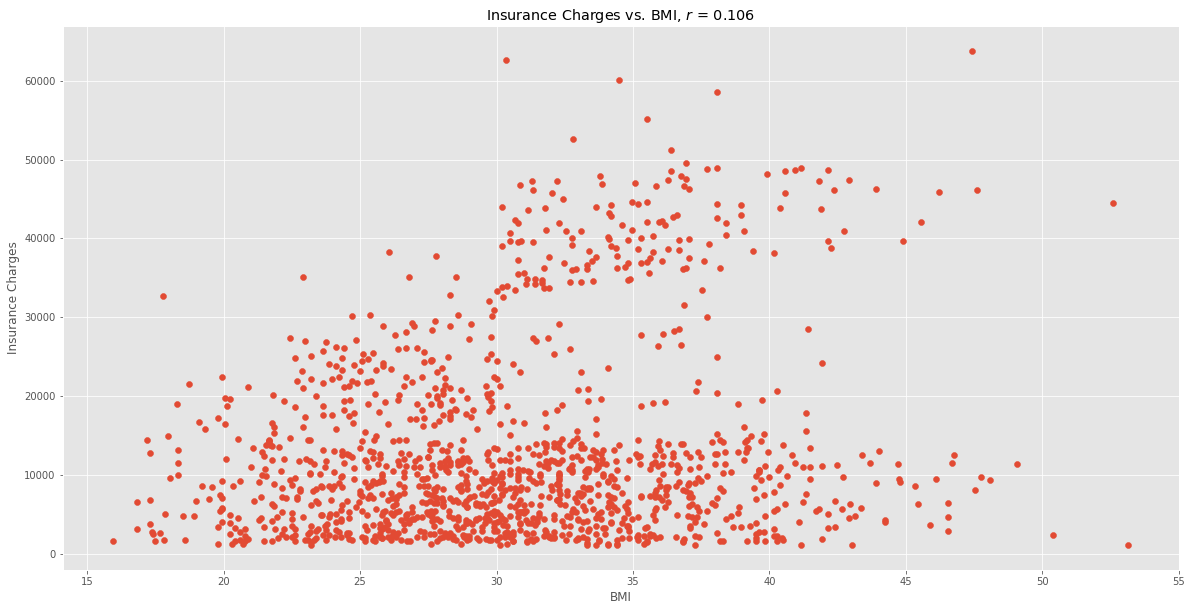

In [69]:
plt.figure(figsize=[20, 10])
plt.scatter(insurance['bmi'], insurance['charges'])
plt.title(r'Insurance Charges vs. BMI, $r$ = ' + str(np.round(correlation(insurance['bmi'], insurance['charges']), 3)))
plt.xlabel('BMI')
plt.ylabel('Insurance Charges');

Based on the fact that the value of $r$ was around 0.1, there might be a _small_ correlation between BMI and insurance charges, but the relationship is not as strong as it could be among other data points. There doesn't seem to be such a huge correlation between BMI and insurance charges, but it kind of looks like there might be something (very) loosely positive there. In order to check, we see if there is perhaps a more linear relationship between BMI and the insurance charges on a log scale:

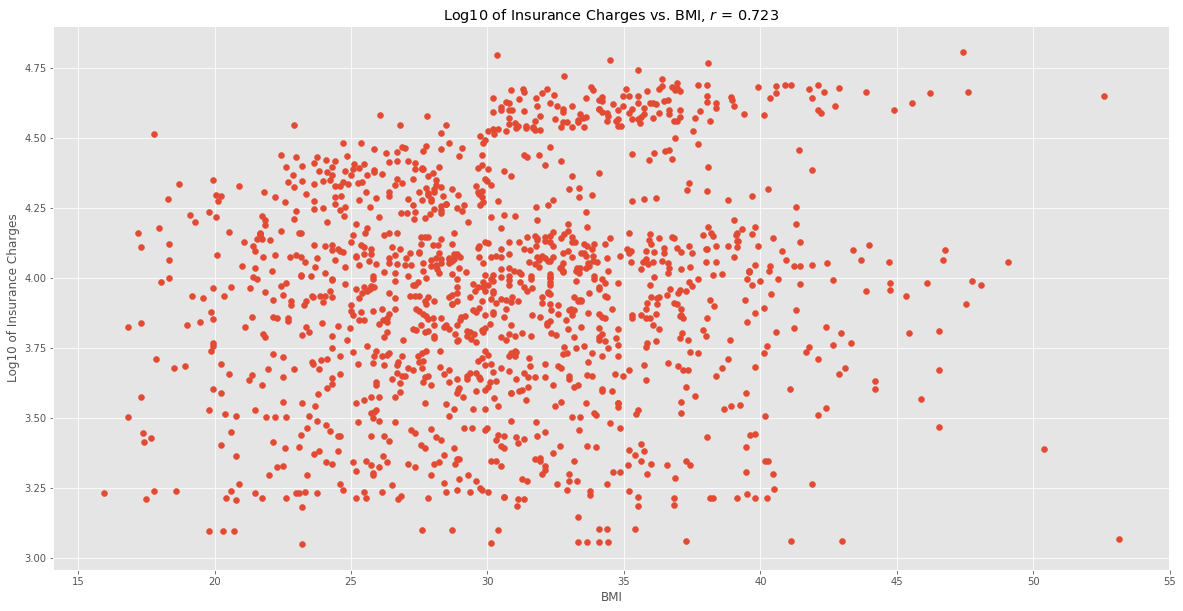

In [70]:
plt.figure(figsize=[20, 10])
plt.scatter(insurance['bmi'], np.log10(insurance['charges']))
plt.title(r'Log10 of Insurance Charges vs. BMI, $r$ = ' + str(np.round(correlation(insurance['bmi'], np.log10(insurance['charges'])), 3)))
plt.xlabel('BMI')
plt.ylabel('Log10 of Insurance Charges');

As it turns out, although the correlation is .7, there really doesn't look to be much there. So while there may be _some_ linear relationship between BMI and insurance charges (or its log), it's not too apparent.

### Does being a smoker affect what you're charged by the insurance company?
**Null Hypothesis**: Being a smoker does not affect your charges; any differences in the observed values are due to random chance.

**Alternative Hypothesis**: Being a smoker _does_ affect what you are charged in insurance premiums.

This question, from a data science perspective, is asking whether or not the charges for the groups `smoker` and `non-smoker` come from the same underlying distribution. To find this out, we use an A/B Test, which involves shuffling up the data in question in a sample _without replacement_, computing a test statistic, and finding the p-value. By convention, if the p-value is less than .05 (meaning less than 5% of the simulated data point in the same direction as the original data set), we lean in the direction of the alternative hypothesis. In this A/B test, the test statistic will be the absolute difference between the mean charges for smokers and non-smokers.

Before doing the actual permutation test, we will run through a single permutation to demonstrate the process that will eventually be done thousands of times to obtain a p-value. The first part of the permutation test is to shuffle up the `charges` column of the `insurance` DataFrame and create a new column with the shuffled-up charges. It is from this _permuting_ of the sample that permutation tests get their name.

In [5]:
smoker_and_charges = insurance[['smoker', 'charges']]
charges_shuffled = list(smoker_and_charges.sample(frac=1)['charges'])
shuffled_charges_df = smoker_and_charges.assign(shuffled_charges=charges_shuffled)
shuffled_charges_df.head()

,smoker,charges,shuffled_charges
0,yes,16884.92400,6600.3610
1,no,1725.55230,12231.6136
2,no,4449.46200,3484.3310
3,no,21984.47061,8442.6670
4,no,3866.85520,42983.4585


The next part of the test is to compute the value of the test statistic, which is the absolute difference between the mean charges for smokers and non-smokers. (A high value of this statistic points in the direction of the alternative hypothesis.) To this end, we define the function `ts` which takes a DataFrame and a column name as its arguments and returns the absolute difference of the mean value of `col_name` after `df` has been grouped by the column `smoker`.

In [6]:
def ts(df, col_name):
    df_grouped = df.groupby('smoker').mean()
    return abs(df_grouped[col_name].iloc[0] - df_grouped[col_name].iloc[1])


# computing the test statistic on the table shuffled_charges_df
test_stat_1 = ts(shuffled_charges_df, 'shuffled_charges')
test_stat_1

668.2917138336725

Finally, we are ready for the permutation test. The function `perm_test` below taks a DataFrame as its argument and the number of replications, `reps`, to go through. For each replication, it permutes `df` as we did above and computes the value of the test statistic, collecting them in the list `stats`. After collecting these values, it computes the test statistic for the _original_ data, and returns a p-value by taking the percentage of test statistics that are _greater than or equal to_ the observed value.

In [7]:
def perm_test(df, reps):
    stats = []
    for _ in np.arange(reps):
        charges_shuffled = list(df.sample(frac=1)['charges'])
        df = df.assign(shuffled_charges=charges_shuffled)
        stat = ts(df, 'shuffled_charges')
        stats += [stat]
        
    observed_ts = ts(df, 'charges')
    
    return np.count_nonzero(stats >= observed_ts) / len(stats)

In [8]:
# run the permutation test with 100,000 repetitions
perm_test(smoker_and_charges, 100000)

0.0

**Conclusion**: Because the p-value is 0, we know that _none_ of the shuffled sets were as far or farther in the direction of the alternative hypothesis than was the original data set; this means that in all likelihood, the observed differences are _not_ due to random chance. Thus, we lean in the direction of the alternative hypothesis: that being a smoker affects what you're charged by insurance companies. Conventional wisdom, I know, but it is still nice to have it proven empirically.